# DeepFake Video Detection

## Documentation

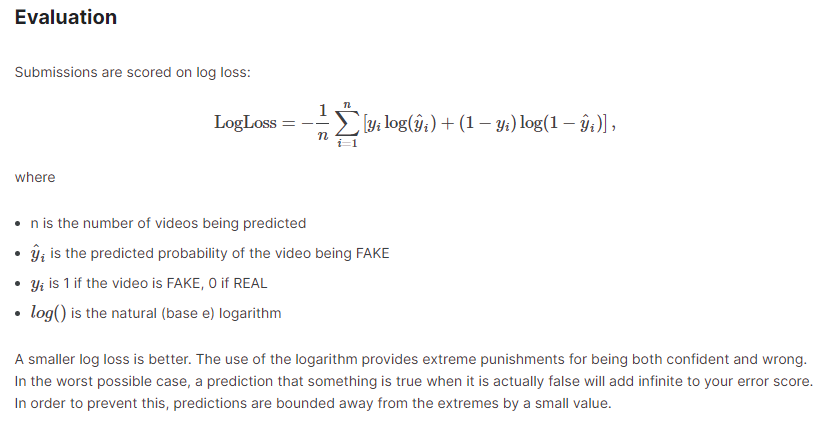

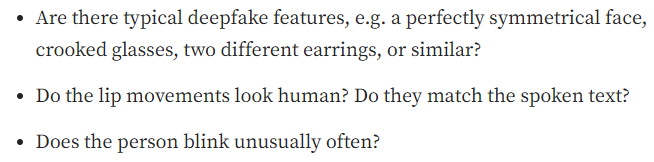

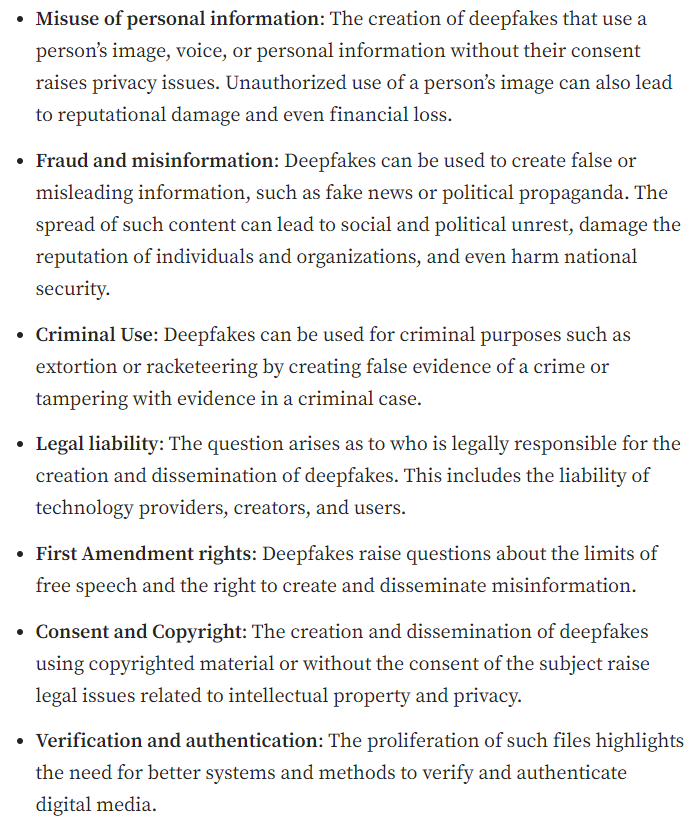

https://towardsdatascience.com/deepfake-detection-is-super-hard-38f98241ee49

## Install Packages

In [190]:
'''
!pip install moviepy
!pip install ffpyplayer
pip install ultralytics
'''

'\n!pip install moviepy\n!pip install ffpyplayer\npip install ultralytics\n'

## Packages and Parameters

In [205]:
# Load packages

import os
from os import path
from typing import Optional
import numpy as np
import pandas as pd
import glob
from tqdm.auto import tqdm

# Deep Learning
import torch
import torch.nn            as nn
import torch.nn.functional as F
import torchinfo
import cv2 as cv

import matplotlib.pyplot as plt

In [215]:
# Parameters

MY_NAME_IS = 'Victor'

TRAIN_PARTS = 40 # 2
TEST_PARTS = 10 # 1

DOWN_FPS = 10
FRAME_SCALE = 0.1
GRAYCOLOR = True

BATCH_SIZE = 3

################################################################################################

DATA_FOLDER_DICT = {
    'Victor': ['E:\DeepFakeDetection\dfdc_train_all','E:\DeepFakeDetection\smalldata'],
    'Nitzan': ['D:\dfdc','D:\dfdc'],
    'Netanel':['F:\input','F:\input']}
BIG_DATA_FOLDER = DATA_FOLDER_DICT[MY_NAME_IS][0]
SMALL_DATA_FOLDER = DATA_FOLDER_DICT[MY_NAME_IS][1]

TORCH_DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'The chosen device: {TORCH_DEVICE}')

SMALLFILE_EXT = 'tns'

The chosen device: cuda


## Data Analysing and Preproccesing

In [216]:
# Load and concat all JSON files

meta_df = pd.DataFrame()
metadata_glob = glob.iglob('**/metadata.json', recursive=True, root_dir=BIG_DATA_FOLDER)
ii = 0
for metadata in metadata_glob:
    metadata_path = path.join(BIG_DATA_FOLDER, metadata)
    dir_path = os.path.dirname(os.path.realpath(metadata_path))
    part_df = pd.read_json(metadata_path).T
    part_df['part'] = ii
    part_df['bigdata_path'] = dir_path
    part_df['smalldata_path'] = f"{SMALL_DATA_FOLDER}\{ii}"
    #part_df['filename'] = part_df.index
    meta_df = pd.concat([meta_df, part_df])
    ii += 1

display(meta_df)

,label,split,original,part,bigdata_path,smalldata_path
owxbbpjpch.mp4,FAKE,train,wynotylpnm.mp4,0,E:\DeepFakeDetection\dfdc_train_all\dfdc_train...,E:\DeepFakeDetection\smalldata\0
vpmyeepbep.mp4,REAL,train,NaN,0,E:\DeepFakeDetection\dfdc_train_all\dfdc_train...,E:\DeepFakeDetection\smalldata\0
fzvpbrzssi.mp4,REAL,train,NaN,0,E:\DeepFakeDetection\dfdc_train_all\dfdc_train...,E:\DeepFakeDetection\smalldata\0
htorvhbcae.mp4,FAKE,train,wclvkepakb.mp4,0,E:\DeepFakeDetection\dfdc_train_all\dfdc_train...,E:\DeepFakeDetection\smalldata\0
fckxaqjbxk.mp4,FAKE,train,vpmyeepbep.mp4,0,E:\DeepFakeDetection\dfdc_train_all\dfdc_train...,E:\DeepFakeDetection\smalldata\0
...,...,...,...,...,...,...
pdooqxqfrm.mp4,FAKE,train,ikebomnsiq.mp4,49,E:\DeepFakeDetection\dfdc_train_all\dfdc_train...,E:\DeepFakeDetection\smalldata\49
djjdcnhlma.mp4,FAKE,train,kudvvlgiff.mp4,49,E:\DeepFakeDetection\dfdc_train_all\dfdc_train...,E:\DeepFakeDetection\smalldata\49
fgmbxfqoze.mp4,REAL,train,NaN,49,E:\DeepFakeDetection\dfdc_train_all\dfdc_train...,E:\DeepFakeDetection\smalldata\49
cywebjaezn.mp4,REAL,train,NaN,49,E:\DeepFakeDetection\dfdc_train_all\dfdc_train...,E:\DeepFakeDetection\smalldata\49


<Axes: title={'center': 'Histogram of Classes / Labels'}, xlabel='Class', ylabel='Count'>

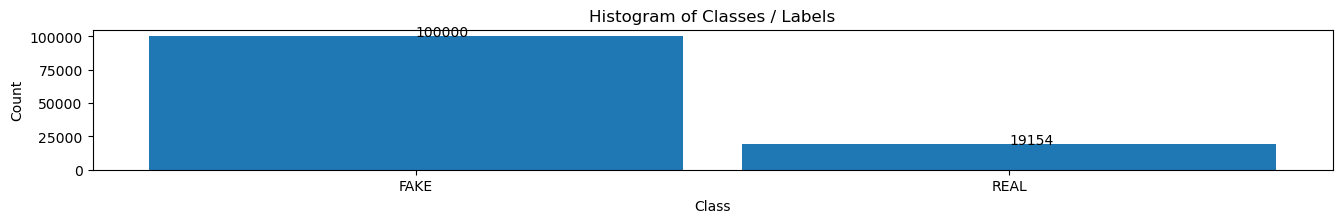

In [198]:
# Histogram

def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i,y[i],y[i])

def PlotLabelsHistogram(vY: np.ndarray, labels_list, hA: Optional[plt.Axes] = None ) -> plt.Axes:
    if hA is None:
        hF, hA = plt.subplots(figsize = (8, 6))
    vLabels, vCounts = np.unique(vY, return_counts = True)
    hA.bar(vLabels, vCounts, width = 0.9, align = 'center')
    addlabels(vLabels, vCounts)
    hA.set_title('Histogram of Classes / Labels')
    hA.set_xlabel('Class')
    hA.set_xticks(vLabels, labels_list)
    hA.set_ylabel('Count')
    return hA

plt.figure(figsize=(16, 4))
ax = plt.subplot(2,1,1)
PlotLabelsHistogram(meta_df['label'],meta_df['label'].unique(),ax)

In [217]:
# Split Data, Take part of data

metadata_train_df = meta_df.loc[meta_df['part']<TRAIN_PARTS]
metadata_test_df = meta_df.loc[meta_df['part']>=TRAIN_PARTS]
metadata_test_df = metadata_test_df.loc[metadata_test_df['part']<TRAIN_PARTS+TEST_PARTS]
metadata_test_df['split'] = 'test'
metadata_df = pd.concat((metadata_train_df,metadata_test_df))
display(metadata_df)

,label,split,original,part,bigdata_path,smalldata_path
owxbbpjpch.mp4,FAKE,train,wynotylpnm.mp4,0,E:\DeepFakeDetection\dfdc_train_all\dfdc_train...,E:\DeepFakeDetection\smalldata\0
vpmyeepbep.mp4,REAL,train,NaN,0,E:\DeepFakeDetection\dfdc_train_all\dfdc_train...,E:\DeepFakeDetection\smalldata\0
fzvpbrzssi.mp4,REAL,train,NaN,0,E:\DeepFakeDetection\dfdc_train_all\dfdc_train...,E:\DeepFakeDetection\smalldata\0
htorvhbcae.mp4,FAKE,train,wclvkepakb.mp4,0,E:\DeepFakeDetection\dfdc_train_all\dfdc_train...,E:\DeepFakeDetection\smalldata\0
fckxaqjbxk.mp4,FAKE,train,vpmyeepbep.mp4,0,E:\DeepFakeDetection\dfdc_train_all\dfdc_train...,E:\DeepFakeDetection\smalldata\0
...,...,...,...,...,...,...
pdooqxqfrm.mp4,FAKE,test,ikebomnsiq.mp4,49,E:\DeepFakeDetection\dfdc_train_all\dfdc_train...,E:\DeepFakeDetection\smalldata\49
djjdcnhlma.mp4,FAKE,test,kudvvlgiff.mp4,49,E:\DeepFakeDetection\dfdc_train_all\dfdc_train...,E:\DeepFakeDetection\smalldata\49
fgmbxfqoze.mp4,REAL,test,NaN,49,E:\DeepFakeDetection\dfdc_train_all\dfdc_train...,E:\DeepFakeDetection\smalldata\49
cywebjaezn.mp4,REAL,test,NaN,49,E:\DeepFakeDetection\dfdc_train_all\dfdc_train...,E:\DeepFakeDetection\smalldata\49


In [200]:
# Load Video: Downgrade video from big data to small

#from moviepy.editor import AudioFileClip

def LoadVideo(filepath,down_fps,scale_fact,isGray):
    video = []
    cap = cv.VideoCapture(filepath)
    fps = cap.get(cv.CAP_PROP_FPS) 
    fcnt = int(cap.get(cv.CAP_PROP_FRAME_COUNT))
    fps_factor = round(fps/down_fps)
    #audio_clip = AudioFileClip(filepath)

    for ii_f in range(fcnt):
        if(cap.isOpened() == False):
            break
        ret, frame = cap.read()
        #sample = audio_clip.get_frame()
        if((ii_f % fps_factor) != 0): # DownFramesPerSecond
            continue
        # if frame is read correctly ret is True
        if not ret:
            break
        height, width, channels = frame.shape
        if(height>width):
            frame = cv.rotate(frame, cv.ROTATE_90_CLOCKWISE)
            height, width, channels = frame.shape
        down_width = round(width*scale_fact)
        down_height = round(height*scale_fact)
        down_points = (down_width, down_height)
        if(isGray):
            frame_sample = cv.resize(cv.cvtColor(frame, cv.COLOR_BGR2GRAY),down_points,interpolation = cv.INTER_LINEAR) # np.resize(frame,down_points) # sample = np.array(frame,sample)
        else:
            frame_sample = cv.resize(cv.cvtColor(frame, cv.COLOR_BGR2RGB),down_points,interpolation = cv.INTER_LINEAR) # frame_sample = cv.resize(cv.cvtColor(frame, cv.COLOR_BGR2RGB),down_points,interpolation = cv.INTER_LINEAR) # np.resize(frame,down_points) # sample = np.array(frame,sample)
        video.append(frame_sample)

    cap.release()
    cv.destroyAllWindows()
    video = np.array(video)
    video = torch.tensor(video)
    return video

In [218]:
# Offline Preprocess
RUN_OFFLINE = 1

if(RUN_OFFLINE):
    for ii in tqdm(range(metadata_df.shape[0]),desc="Downgrading videos"):
        bigfilepath = f"{metadata_df['bigdata_path'].iloc[ii]}\{metadata_df.index[ii]}"
        smallfilepath = f"{metadata_df['smalldata_path'].iloc[ii]}\{metadata_df.index[ii]}"
        smallfilepath = f"{smallfilepath[0:-4]}.{SMALLFILE_EXT}"
        video = LoadVideo(bigfilepath,DOWN_FPS,FRAME_SCALE,GRAYCOLOR)
        if(os.path.exists(metadata_df['smalldata_path'].iloc[ii])==False):
            os.makedirs(metadata_df['smalldata_path'].iloc[ii])
        torch.save(video,smallfilepath)

Downgrading videos:   0%|          | 0/119154 [00:00<?, ?it/s]

## Data Analyze

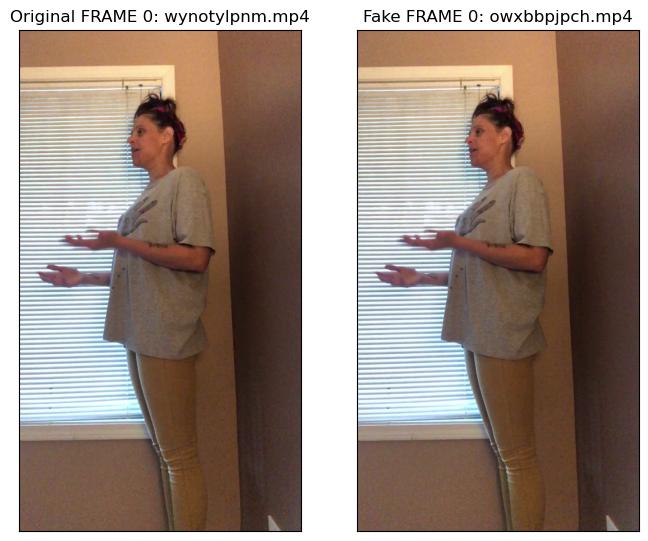

In [27]:
fake_mdata = meta_df[meta_df["label"]=="FAKE"].iloc[[0],:]
filedir = fake_mdata["path"][0]
fake_filename = fake_mdata.index[0]
orig_filename = fake_mdata["original"][0]
fake_filepath = filedir + "\\" + fake_filename
orig_filepath = filedir + "\\" + orig_filename

cap = cv.VideoCapture(orig_filepath)
success, image = cap.read()
orig_image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
cap.release() 
cap = cv.VideoCapture(fake_filepath)
success, image = cap.read()
fake_image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
cap.release() 

fig, ax = plt.subplots(1,2, figsize=(8, 7))
ax[0].imshow(orig_image)
ax[0].xaxis.set_visible(False)
ax[0].yaxis.set_visible(False)
ax[0].title.set_text(f"Original FRAME 0: {orig_filename}")
plt.grid(False)
ax[1].imshow(fake_image)
ax[1].xaxis.set_visible(False)
ax[1].yaxis.set_visible(False)
ax[1].title.set_text(f"Fake FRAME 0: {fake_filename}")
plt.grid(False)


In [ ]:
'''
from moviepy.editor import *

video = VideoFileClip(fake_filepath)
video.ipython_display(width=256)
'''

In [ ]:
'''
cap = cv.VideoCapture(fake_filepath)
 
while cap.isOpened():
    ret, frame = cap.read()

    # if frame is read correctly ret is True
    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break
    #gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)

    cv.imshow('frame',frame) # , gray
    if cv.waitKey(1) == ord('q'):
        break
 
cap.release()
cv.destroyAllWindows()
'''

In [ ]:
from moviepy.editor import AudioFileClip

audio_clip = AudioFileClip('E:\\DeepFakeDetection\\dfdc_train_all\\dfdc_train_part_00\\dfdc_train_part_0\\aaqaifqrwn.mp4')

sample = audio_clip.reader.buffer
display(sample.shape)

sample = audio_clip.get_frame(1)
display(sample)

In [73]:
video = LoadVideo('E:\\DeepFakeDetection\\dfdc_train_all\\dfdc_train_part_00\\dfdc_train_part_0\\omrtielsni.mp4',10,0.1,True)
display(video.dtype)
display(video.shape)


torch.uint8

torch.Size([100, 108, 192])

torch.Size([108, 192])

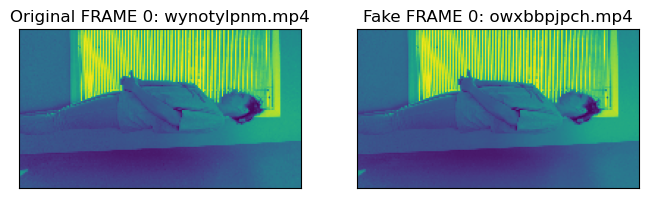

In [80]:
fig, ax = plt.subplots(1,2, figsize=(8, 7))
v1 = video[0,:,:]
display(v1.shape)
ax[0].imshow(video[0,:,:])
ax[0].xaxis.set_visible(False)
ax[0].yaxis.set_visible(False)
ax[0].title.set_text(f"Original FRAME 0: {orig_filename}")
plt.grid(False)
ax[1].imshow(video[1,:,:])
ax[1].xaxis.set_visible(False)
ax[1].yaxis.set_visible(False)
ax[1].title.set_text(f"Fake FRAME 0: {fake_filename}")
plt.grid(False)

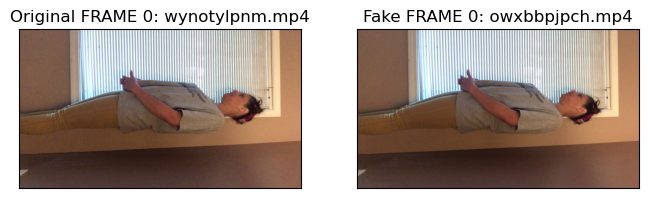
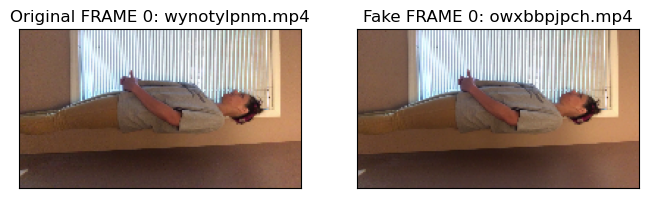
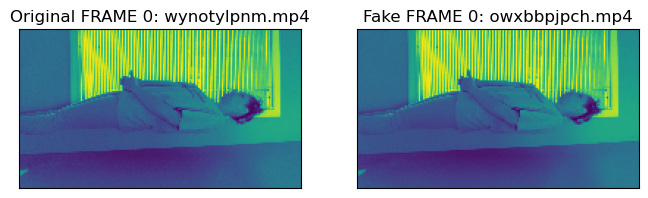

In [82]:
# 119197 * 300 * 1920 * 1080 * 3 / (16*1024*1024*1024)
display(300 * 1920 * 1080 * 3 / (1024*1024*1024))
display(100 * 1920 * 1080 * 3 / (1024*1024*1024))
display(100 * 108 * 192 / (1024*1024))

1.7380714416503906

0.5793571472167969

1.9775390625

## Pytorch

In [ ]:
class MyIterableDataset(torch.utils.data.IterableDataset):
    def __init__(self,data_path):
        super(MyIterableDataset).__init__()
        self.data_path = data_path
    def __iter__(self):
        # frames = LoadVideo(fake_filepath)
        return iter(range(iter_start, iter_end))
    
# should give same set of data as range(3, 7), i.e., [3, 4, 5, 6].
ds = MyIterableDataset(start=3, end=7)

torch.utils.data.DataLoader(ds, num_workers=0)

In [ ]:
dlTrain  = torch.utils.data.DataLoader(dsTrain, shuffle = True, batch_size = 1 * batchSize, num_workers = numWork, persistent_workers = True)

In [6]:
oModel = nn.Sequential(
    nn.Identity(),                            #<! For the summary (Shows the input)
    nn.Linear(100, 50),            nn.ReLU(), #<! z1 = σ(W1 * x + b1)
    nn.Linear(50,  25),            nn.ReLU(), #<! z2 = σ(W2 * z1 + b2)
    nn.Linear(25,  10, bias = False)          #<! y  = W3 * z2 (No Bias)
    )

numSamples  = 16
dataDim     = 100
display(torchinfo.summary(oModel, input_size = (numSamples, dataDim))) #<! By default tries on CUDA
print(f'The model device: {next(oModel.parameters()).device}')

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [16, 10]                  --
├─Identity: 1-1                          [16, 100]                 --
├─Linear: 1-2                            [16, 50]                  5,050
├─ReLU: 1-3                              [16, 50]                  --
├─Linear: 1-4                            [16, 25]                  1,275
├─ReLU: 1-5                              [16, 25]                  --
├─Linear: 1-6                            [16, 10]                  250
Total params: 6,575
Trainable params: 6,575
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.11
Input size (MB): 0.01
Forward/backward pass size (MB): 0.01
Params size (MB): 0.03
Estimated Total Size (MB): 0.04

The model device: cuda:0
